# Import packages

In [1]:
import tomllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import curve_curator
from curve_curator import models
curve_curator.__version__

'0.6.dev'

# Load the fitted data from curves.txt file using pandas

In [4]:
# Load curves.txt file
example_dataset = '../example_datasets/decryptM_Dasatinib/curves.txt'
curves_df = pd.read_csv(example_dataset, sep='\t')
curves_df.head()

,Modified sequence,N duplicates,Genes,Proteins,Score,Raw 1,Raw 2,Raw 3,Raw 4,Raw 5,...,Null Model,Null RMSE,Curve F_Value,Curve P_Value,Curve Log P_Value,Curve F_Value SAM Corrected,Curve Relevance Score,Curve Regulation,Decoy,Curve q_Value
0,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,2,PABPN1,Q86U42-2;Q86U42,113.780,53175.000,84204.0,77624.0,132371.0,85506.0,...,1.015718,0.122428,0.544793,0.817028,0.087763,0.145821,0.000215,NaN,False,0.826549
1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,4,EIF3J,O75822-2;O75822-3;O75822,196.810,1390502.500,1917866.4,1793465.0,2782432.0,2428175.0,...,0.997955,0.046399,1.063936,0.515553,0.287727,0.066180,-0.000000,not,False,0.883979
2,(ac)AAAAAAAGDSDS(ph)WDADAFSVEDPVRK,1,EIF3J,O75822-2;O75822-3;O75822,103.630,15466.000,17080.0,15415.0,21662.0,20551.0,...,0.905875,0.169470,2.672817,0.143568,0.842943,0.834055,0.196692,NaN,False,0.507983
3,(ac)AAAAPDSRVS(ph)EEENLKK,1,RRP15,Q9Y3B9,92.492,199120.000,248650.0,325840.0,520420.0,406510.0,...,1.097047,0.156628,0.660940,0.741589,0.129836,0.179042,0.001529,NaN,False,0.819833
4,(ac)AAAITDMADLEELSRLS(ph)PLPPGS(ph)PGSAAR,2,AEBP2,Q6ZN18-2;Q6ZN18,142.270,6329.655,7332.3,8287.5,11162.4,7860.1,...,1.393061,0.214934,1.579171,0.327465,0.484836,0.104195,-0.000000,NaN,False,0.850875


# Define experiment specific values manually or from the toml file automatically

#### Manual:

In [5]:
# define columns from the curves file 
experiments = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # all expeimrent names that are not zero.
ratio_cols = [f'Ratio {name}' for name in experiments]

# X data in nM (1e-9) is converted in log10 space. All doses that are not zero.
x = np.log10([100.0, 30.0, 10.0, 3.0, 1.0, 0.3, 0.1, 0.03, 0.01]) - 9 

#### From toml:

In [6]:
# Load toml file parameters
example_dataset_toml = '../example_datasets/decryptM_Dasatinib/parameters.toml'
config = tomllib.load(open(example_dataset_toml, "rb"))

# load experiment information
experiments = np.array(config['Experiment']['experiments'])
x = np.log10(np.array(config['Experiment']['doses']) * float(config['Experiment']['dose_scale']))
assert len(x) == len(experiments)

# filter for valid concentrations
zero_mask = np.isfinite(x)
experiments = experiments[zero_mask]
x = x[zero_mask]

# define ratio columns
ratio_cols = [f'Ratio {name}' for name in experiments]

/var/folders/pl/nnvf0lxx2gg0d0lsc79pc4k00000gn/T/ipykernel_97936/2895192602.py:7: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.array(config['Experiment']['doses']) * float(config['Experiment']['dose_scale']))


# Create CurveCurator models with fitted parameters

models.LogisticModel is the 4-parameter logistic modle object. It can be loaded with parameters: ['pEC50', 'Curve Slope', 'Curve Front', 'Curve Back']

models.MeanModel is the mean modle object and should be used for not curves. It can be loaded with parameters: ['Null Model']

In [7]:
# columns from the curves.txt file with the relevant information
param_lm_cols = ['pEC50', 'Curve Slope', 'Curve Front', 'Curve Back']
param_mm_cols = ['Null Model']

# select a specific curve: get the experimental y ratio valuesand get the fitted parameters of the logistic and mean model
mod_seq = 'ELFDDPSY(ph)VNVQNLDK'
curve_mask = (curves_df['Modified sequence'] == mod_seq)
y = curves_df.loc[curve_mask, ratio_cols].iloc[0].values
params_lm = curves_df.loc[curve_mask, param_lm_cols].iloc[0].values
params_mm = curves_df.loc[curve_mask, param_mm_cols].iloc[0].values

# load curve curator models with fitted params
LM = models.LogisticModel(*params_lm)
print(LM)

MM = models.MeanModel(*params_mm)
print(MM)

LogisticModel({'pec50': 8.287124284686435, 'slope': 3.4680985043562456, 'front': 1.076561638042248, 'back': 0.0102824411574259})
MeanModel({'intercept': 0.7522487392283652})


# Plot a dose-response curve with data points and fitted model

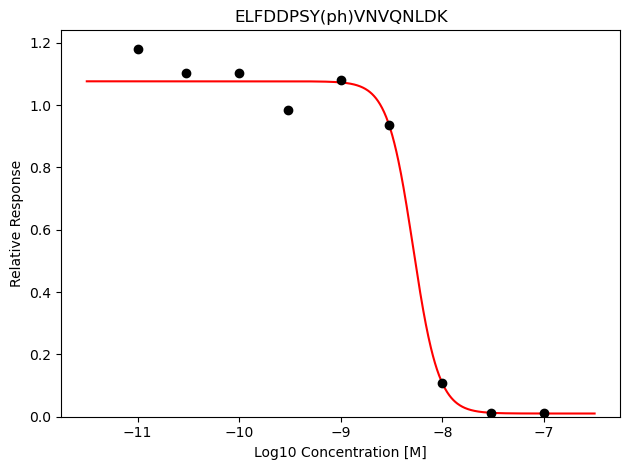

In [8]:
# Automatically define x values for the model from experimental drug range
line_x = np.linspace(min(x) - .5, max(x) + .5, 1000)

# Predict y values based on regressed model.
# For significant curves use the Logistic model. 
# For not curves we typically report the MeanModel as constant line.
line_y = LM(line_x)
#line_y = MM(line_x)

# plot with matplotlib
plt.plot(line_x, line_y, color='red', zorder=1) 
plt.scatter(x, y, color='black', zorder=2)
plt.xlabel('Log10 Concentration [M]')
plt.ylabel('Relative Response')
plt.ylim(0, None)
plt.title(mod_seq)
plt.tight_layout()
plt.savefig('./my_curve.pdf', transparent=True)
plt.show()
plt.close()